
# Imports


In [1]:
import os
import cv2
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
from scipy.signal import stft
from tabulate import tabulate



# Custom Transforms


In [2]:
class DCTTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        dct = cv2.dct(np.float32(img))
        dct = cv2.resize(dct, (224, 224))
        dct = np.stack([dct, dct, dct], axis=-1)
        return torch.tensor(dct.transpose(2, 0, 1), dtype=torch.float32)

class STFTTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # STFT
        f, t, Zxx = stft(img, nperseg=64)
        magnitude = np.abs(Zxx)

        # --- FIX: Ensure 2D always ---
        if magnitude.ndim > 2:  
            magnitude = magnitude[:, :, 0]  # take first channel if extra dims

        # Resize to (224,224)
        magnitude = cv2.resize(magnitude, (224, 224))

        # Force shape (224,224,3)
        magnitude = np.repeat(magnitude[..., np.newaxis], 3, axis=-1)

        # Convert to CHW tensor
        return torch.tensor(magnitude.transpose(2, 0, 1), dtype=torch.float32)



class WaveletTransform:
    def __call__(self, img):
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        coeffs2 = pywt.dwt2(img, 'haar')
        LL, (LH, HL, HH) = coeffs2
        wavelet_img = np.abs(LL)
        wavelet_img = cv2.resize(wavelet_img, (224, 224))
        wavelet_img = np.stack([wavelet_img, wavelet_img, wavelet_img], axis=-1)
        return torch.tensor(wavelet_img.transpose(2, 0, 1), dtype=torch.float32)

class LearnableFrequencyTransform(nn.Module):
    def __init__(self):
        super(LearnableFrequencyTransform, self).__init__()
        self.freq_filter = nn.Parameter(torch.randn(1, 224, 224))

    def forward(self, img):
        if isinstance(img, torch.Tensor):
            img = img.squeeze().numpy()
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (224, 224))
        img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        filtered = img_tensor * self.freq_filter
        filtered = filtered.squeeze(0).detach().numpy()
        filtered = np.stack([filtered, filtered, filtered], axis=-1)
        return torch.tensor(filtered.transpose(2, 0, 1), dtype=torch.float32)



# Multi-Transform Dataset


In [3]:
class MultiTransformDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms_dict):
        self.dataset = datasets.ImageFolder(root=root)
        self.transforms_dict = transforms_dict

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        outputs = {k: t(img) for k, t in self.transforms_dict.items()}
        return outputs, label


# Mid-Fusion Network


In [4]:
# class MidFusionNet(nn.Module):
#     def __init__(self, num_classes=5, dropout=0.4):
#         super(MidFusionNet, self).__init__()

#         # MobileNetV2
#         mobilenet = models.mobilenet_v2(weights="IMAGENET1K_V1")
#         mnv2_block1 = mobilenet.features[:7]
#         mnv2_block2 = mobilenet.features[7:14]
#         mnv2_out_channels = 96

#         # ConvNeXt-Tiny
#         convnext = models.convnext_tiny(weights="IMAGENET1K_V1")
#         cnx_block1 = nn.Sequential(*convnext.features[:3])
#         cnx_block2 = nn.Sequential(*convnext.features[3:6])
#         cnx_out_channels = 192

#         # 8 Branches (4 features × 2 backbones)
#         self.branches = nn.ModuleDict({
#             "mnv2_dct": nn.Sequential(mnv2_block1, mnv2_block2),
#             "mnv2_stft": nn.Sequential(mnv2_block1, mnv2_block2),
#             "mnv2_wave": nn.Sequential(mnv2_block1, mnv2_block2),
#             "mnv2_learn": nn.Sequential(mnv2_block1, mnv2_block2),

#             "cnx_dct": nn.Sequential(cnx_block1, cnx_block2),
#             "cnx_stft": nn.Sequential(cnx_block1, cnx_block2),
#             "cnx_wave": nn.Sequential(cnx_block1, cnx_block2),
#             "cnx_learn": nn.Sequential(cnx_block1, cnx_block2),
#         })

#         # Fusion layer
#         fused_dim = (mnv2_out_channels + cnx_out_channels) * 4
#         self.fusion_encoder = nn.Sequential(
#             nn.Conv2d(fused_dim, 512, kernel_size=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1, 1))
#         )

#         # Classifier
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Dropout(dropout),
#             nn.Linear(512, num_classes)
#         )

#     def forward(self, inputs):
#         feats = []
#         feats.append(self.branches["mnv2_dct"](inputs["dct"]))
#         feats.append(self.branches["mnv2_stft"](inputs["stft"]))
#         feats.append(self.branches["mnv2_wave"](inputs["wavelet"]))
#         feats.append(self.branches["mnv2_learn"](inputs["learn"]))
#         feats.append(self.branches["cnx_dct"](inputs["dct"]))
#         feats.append(self.branches["cnx_stft"](inputs["stft"]))
#         feats.append(self.branches["cnx_wave"](inputs["wavelet"]))
#         feats.append(self.branches["cnx_learn"](inputs["learn"]))

#         fused = torch.cat(feats, dim=1)
#         fused = self.fusion_encoder(fused)
#         out = self.classifier(fused)
#         return out




# =====================
# Mid-Fusion Network (Dynamic fused_dim)
# =====================
class MidFusionNet(nn.Module):
    def __init__(self, num_classes=5, dropout=0.4):
        super(MidFusionNet, self).__init__()

        # MobileNetV2
        mobilenet = models.mobilenet_v2(weights="IMAGENET1K_V1")
        mnv2_block1 = mobilenet.features[:7]
        mnv2_block2 = mobilenet.features[7:14]

        # ConvNeXt-Tiny
        convnext = models.convnext_tiny(weights="IMAGENET1K_V1")
        cnx_block1 = nn.Sequential(*convnext.features[:3])
        cnx_block2 = nn.Sequential(*convnext.features[3:6])

        # 8 Branches (4 features × 2 backbones)
        self.branches = nn.ModuleDict({
            "mnv2_dct": nn.Sequential(mnv2_block1, mnv2_block2),
            "mnv2_stft": nn.Sequential(mnv2_block1, mnv2_block2),
            "mnv2_wave": nn.Sequential(mnv2_block1, mnv2_block2),
            "mnv2_learn": nn.Sequential(mnv2_block1, mnv2_block2),

            "cnx_dct": nn.Sequential(cnx_block1, cnx_block2),
            "cnx_stft": nn.Sequential(cnx_block1, cnx_block2),
            "cnx_wave": nn.Sequential(cnx_block1, cnx_block2),
            "cnx_learn": nn.Sequential(cnx_block1, cnx_block2),
        })

        # --------- DYNAMIC fused_dim calculation ----------
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)  # fake input
            feats = []
            feats.append(self.branches["mnv2_dct"](dummy))
            feats.append(self.branches["mnv2_stft"](dummy))
            feats.append(self.branches["mnv2_wave"](dummy))
            feats.append(self.branches["mnv2_learn"](dummy))
            feats.append(self.branches["cnx_dct"](dummy))
            feats.append(self.branches["cnx_stft"](dummy))
            feats.append(self.branches["cnx_wave"](dummy))
            feats.append(self.branches["cnx_learn"](dummy))
            fused_dim = torch.cat(feats, dim=1).shape[1]  # <--- get channels automatically

        # Fusion layer
        self.fusion_encoder = nn.Sequential(
            nn.Conv2d(fused_dim, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, inputs):
        feats = []
        feats.append(self.branches["mnv2_dct"](inputs["dct"]))
        feats.append(self.branches["mnv2_stft"](inputs["stft"]))
        feats.append(self.branches["mnv2_wave"](inputs["wavelet"]))
        feats.append(self.branches["mnv2_learn"](inputs["learn"]))
        feats.append(self.branches["cnx_dct"](inputs["dct"]))
        feats.append(self.branches["cnx_stft"](inputs["stft"]))
        feats.append(self.branches["cnx_wave"](inputs["wavelet"]))
        feats.append(self.branches["cnx_learn"](inputs["learn"]))

        fused = torch.cat(feats, dim=1)
        fused = self.fusion_encoder(fused)
        out = self.classifier(fused)
        return out



# CONFIGURATION


In [5]:
config = {
    "epochs": 50,
    "batch_size": 8,  # keep small for 8 branches!
    "lr": 1e-4,
    "early_stopping_patience": 7,
    "dropout": 0.4,
    "num_classes": 5,
    "train_dir": "/kaggle/input/casava-plant-diseases/Train_Images/Train_Images",
    "val_dir": "/kaggle/input/casava-plant-diseases/Val_Images/Val_Images",
    "test_dir": "/kaggle/input/casava-plant-diseases/Test_Images/Test_Images",
    "save_dir": "/kaggle/working/FusionNet",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}
os.makedirs(config["save_dir"], exist_ok=True)


# Transforms Dict


In [6]:
transforms_dict = {
    "dct": transforms.Compose([DCTTransform(), transforms.Normalize([0.5], [0.5])]),
    "stft": transforms.Compose([STFTTransform(), transforms.Normalize([0.5], [0.5])]),
    "wavelet": transforms.Compose([WaveletTransform(), transforms.Normalize([0.5], [0.5])]),
    "learn": transforms.Compose([LearnableFrequencyTransform(), transforms.Normalize([0.5], [0.5])])
}


# Dataset & DataLoaders


In [7]:
train_dataset = MultiTransformDataset(config["train_dir"], transforms_dict)
val_dataset = MultiTransformDataset(config["val_dir"], transforms_dict)
test_dataset = MultiTransformDataset(config["test_dir"], transforms_dict)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)
# =====================
# Model, Loss, Optimizer
# =====================
model = MidFusionNet(num_classes=config["num_classes"], dropout=config["dropout"]).to(config["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])



Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 168MB/s]
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 197MB/s] 



# Training Function

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_loss = float("inf")
    patience_counter = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = {k: v.to(config["device"]) for k, v in inputs.items()}
            labels = labels.to(config["device"])

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = {k: v.to(config["device"]) for k, v in inputs.items()}
                labels = labels.to(config["device"])
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            save_path = os.path.join(config["save_dir"], "fusionnet_best.pth")
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Plot curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend(), plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend(), plt.title("Accuracy Curve")
    plt.show()


# Evaluation Function


In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = {k: v.to(config["device"]) for k, v in inputs.items()}
            labels = labels.to(config["device"])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    metrics_table = [
        ["Accuracy", f"{acc:.4f}"],
        ["Precision", f"{prec:.4f}"],
        ["Recall", f"{rec:.4f}"],
        ["F1 Score", f"{f1:.4f}"]
    ]
    print("\n=== Evaluation Results ===")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_loader.dataset.dataset.classes,
                yticklabels=test_loader.dataset.dataset.classes)
    plt.xlabel("Predicted"), plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()



# Run


Epoch 1/50: 100%|██████████| 1570/1570 [36:28<00:00,  1.39s/it]


Epoch 1/50 - Train Loss: 0.7674, Train Acc: 0.7265, Val Loss: 0.6424, Val Acc: 0.7759


Epoch 2/50: 100%|██████████| 1570/1570 [35:51<00:00,  1.37s/it]


Epoch 2/50 - Train Loss: 0.5195, Train Acc: 0.8165, Val Loss: 0.7487, Val Acc: 0.7135


Epoch 3/50: 100%|██████████| 1570/1570 [35:28<00:00,  1.36s/it]


Epoch 3/50 - Train Loss: 0.3431, Train Acc: 0.8824, Val Loss: 0.5797, Val Acc: 0.7993


Epoch 4/50: 100%|██████████| 1570/1570 [35:20<00:00,  1.35s/it]


Epoch 4/50 - Train Loss: 0.2112, Train Acc: 0.9298, Val Loss: 0.5652, Val Acc: 0.8049


Epoch 5/50: 100%|██████████| 1570/1570 [35:56<00:00,  1.37s/it]


Epoch 5/50 - Train Loss: 0.1286, Train Acc: 0.9598, Val Loss: 0.6536, Val Acc: 0.8023


Epoch 6/50: 100%|██████████| 1570/1570 [35:50<00:00,  1.37s/it]


Epoch 6/50 - Train Loss: 0.1044, Train Acc: 0.9691, Val Loss: 0.7205, Val Acc: 0.7956


Epoch 7/50: 100%|██████████| 1570/1570 [35:39<00:00,  1.36s/it]


Epoch 7/50 - Train Loss: 0.0839, Train Acc: 0.9724, Val Loss: 0.9620, Val Acc: 0.6715


Epoch 8/50: 100%|██████████| 1570/1570 [35:22<00:00,  1.35s/it]


Epoch 8/50 - Train Loss: 0.0750, Train Acc: 0.9770, Val Loss: 0.7129, Val Acc: 0.7971


Epoch 9/50: 100%|██████████| 1570/1570 [35:17<00:00,  1.35s/it]


Epoch 9/50 - Train Loss: 0.0688, Train Acc: 0.9802, Val Loss: 0.9201, Val Acc: 0.7726


Epoch 10/50: 100%|██████████| 1570/1570 [35:38<00:00,  1.36s/it]


Epoch 10/50 - Train Loss: 0.0687, Train Acc: 0.9779, Val Loss: 0.7923, Val Acc: 0.7834


Epoch 11/50: 100%|██████████| 1570/1570 [35:36<00:00,  1.36s/it]


Epoch 11/50 - Train Loss: 0.0621, Train Acc: 0.9797, Val Loss: 0.7919, Val Acc: 0.7926
Early stopping triggered!


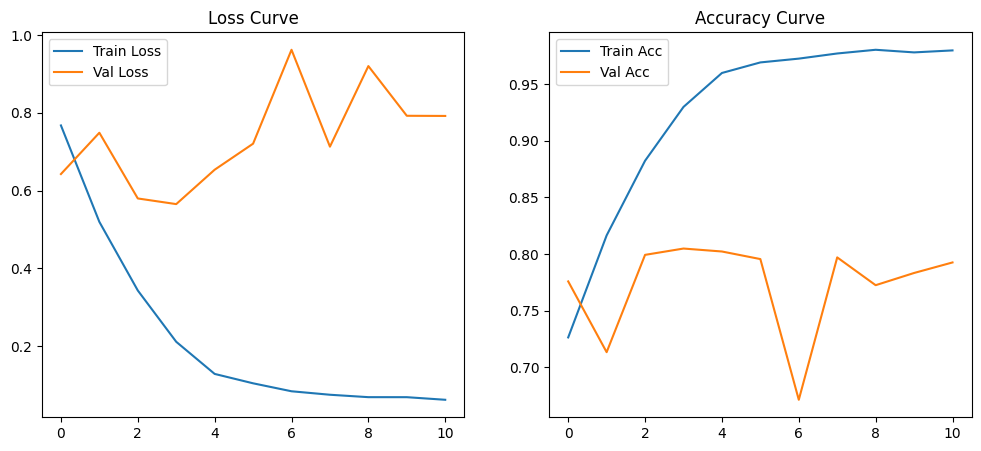


=== Evaluation Results ===
+-----------+---------+
| Metric    |   Value |
+===========+=========+
| Accuracy  |  0.8109 |
+-----------+---------+
| Precision |  0.8207 |
+-----------+---------+
| Recall    |  0.8109 |
+-----------+---------+
| F1 Score  |  0.8136 |
+-----------+---------+


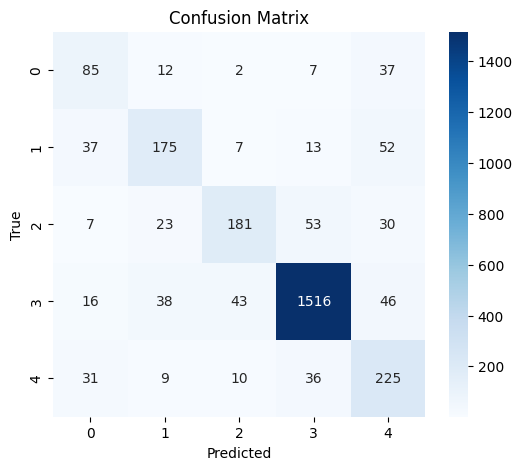

In [10]:
train_model(model, train_loader, val_loader, criterion, optimizer,
            config["epochs"], config["early_stopping_patience"])

best_model_path = os.path.join(config["save_dir"], "fusionnet_best.pth")
model.load_state_dict(torch.load(best_model_path, map_location=config["device"]))
evaluate_model(model, test_loader)
